# Text Classification task on news

---



This notebook presents a  Natural Language Processing (NLP) pipeline for classifying news articles. The dataset sourced from Kaggle includes categorized news articles in World, Sports, Business, and Science/Technology. Automating this process aids in efficient content management and offering personalized news updates to users.


Importing the necessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load and Explore the Dataset

First, we load the dataset


In [ ]:
df = pd.read_csv('news.csv', encoding='latin1')
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


# Data Visualization

Before we begin data preprocessing and model building, it's essential to explore the dataset to understand its structure and features. A key element to inspect is the distribution of classes to ensure the dataset is balanced.

we will Combine the Title and Description into a single text field to streamline data processing and improve the clarity of the information presented.


Label Distribution Before Balancing:
Class Index
1    7795
4    7779
2    7355
3    7043
Name: count, dtype: int64


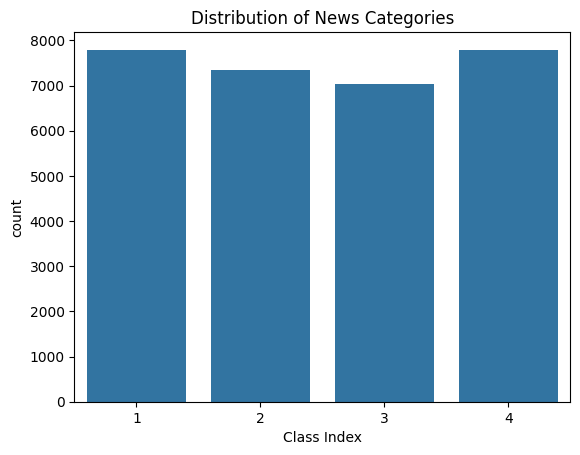

In [ ]:
df['text'] = df['Title'] + " " + df['Description']
df = df[['text', 'Class Index']]
label_distribution = df['Class Index'].value_counts()
print("Label Distribution Before Balancing:")
print(label_distribution)
sns.countplot(x='Class Index', data=df)
plt.title('Distribution of News Categories')
plt.show()

As we can see in the bar chart, the dataset is almost balanced, with a relatively even number of instances across the different classes.


lets do some more visualization

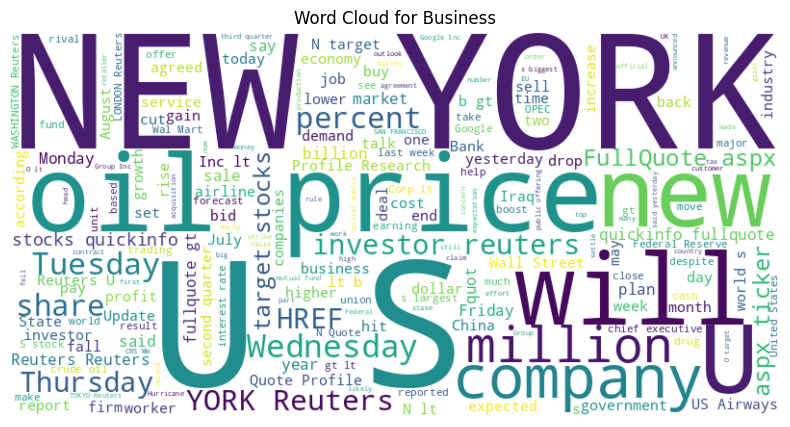

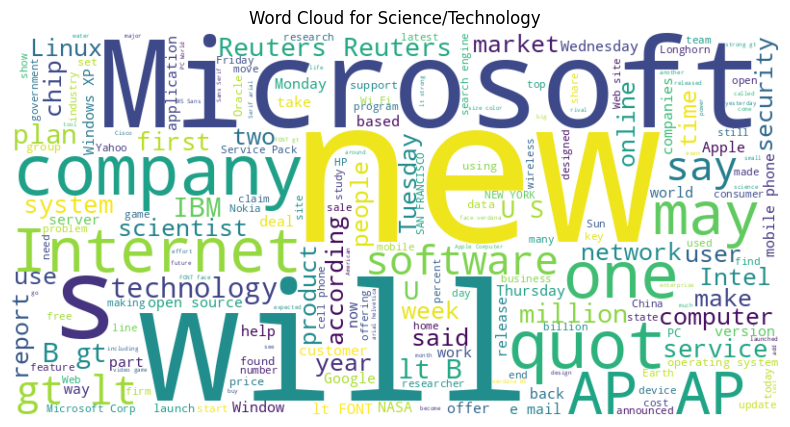

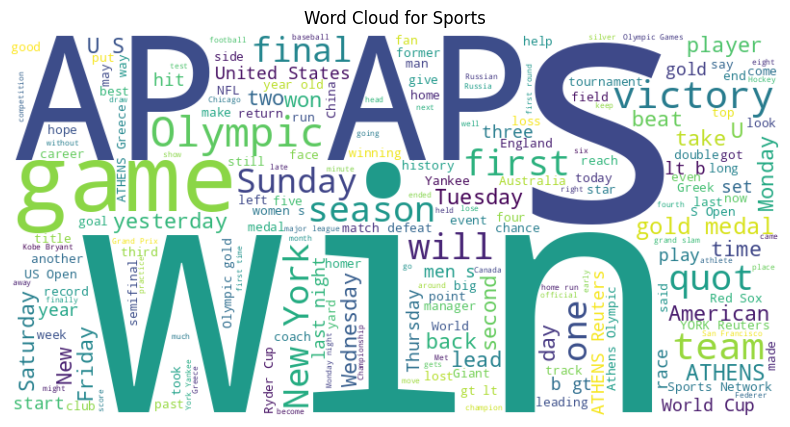

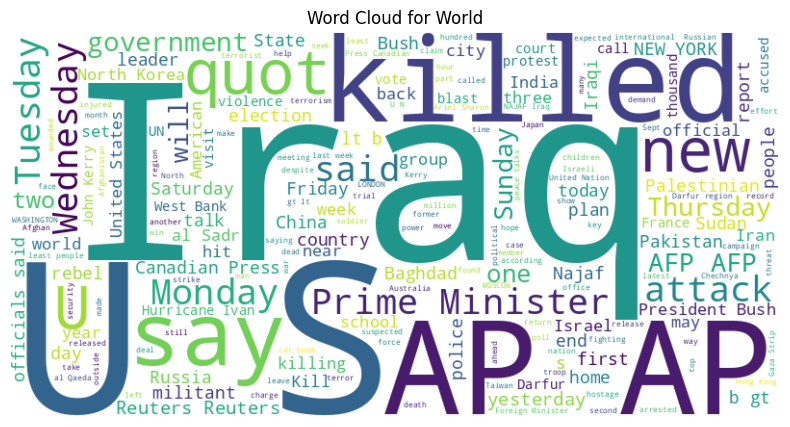

In [ ]:
category_mapping = {
    1: 'World',
    2: 'Sports',
    3: 'Business',
    4: 'Science/Technology'
}
df['category'] = df['Class Index'].map(category_mapping)

categories = df['category'].unique()

for category in categories:
    text = " ".join(article for article in df[df['category'] == category].text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()

above we visualized the most common words in articles across different categories by creating word clouds, making it easier to identify key themes and topics in each category.

word count

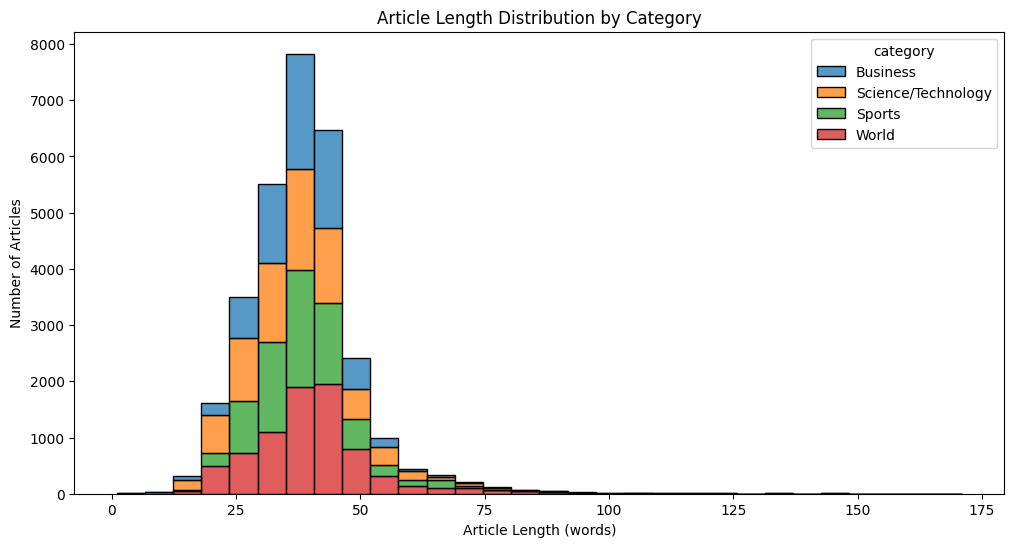

In [ ]:
df['article_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='article_length', hue='category', multiple='stack', bins=30)
plt.title('Article Length Distribution by Category')
plt.xlabel('Article Length (words)')
plt.ylabel('Number of Articles')
plt.show()

as we can see above we analyzed the length of articles by calculating the word count for each article and visualizing the distribution of article lengths across different categories using a stacked histogram. This helps to understand how article lengths vary by category and identify any patterns or trends in article length.

<ipython-input-31-bbdc6c4d3895>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_df, palette='viridis')
<ipython-input-31-bbdc6c4d3895>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_df, palette='viridis')
<ipython-input-31-bbdc6c4d3895>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_df, palette='viridis')
<ipython-input-31-bbdc6c4d3895>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

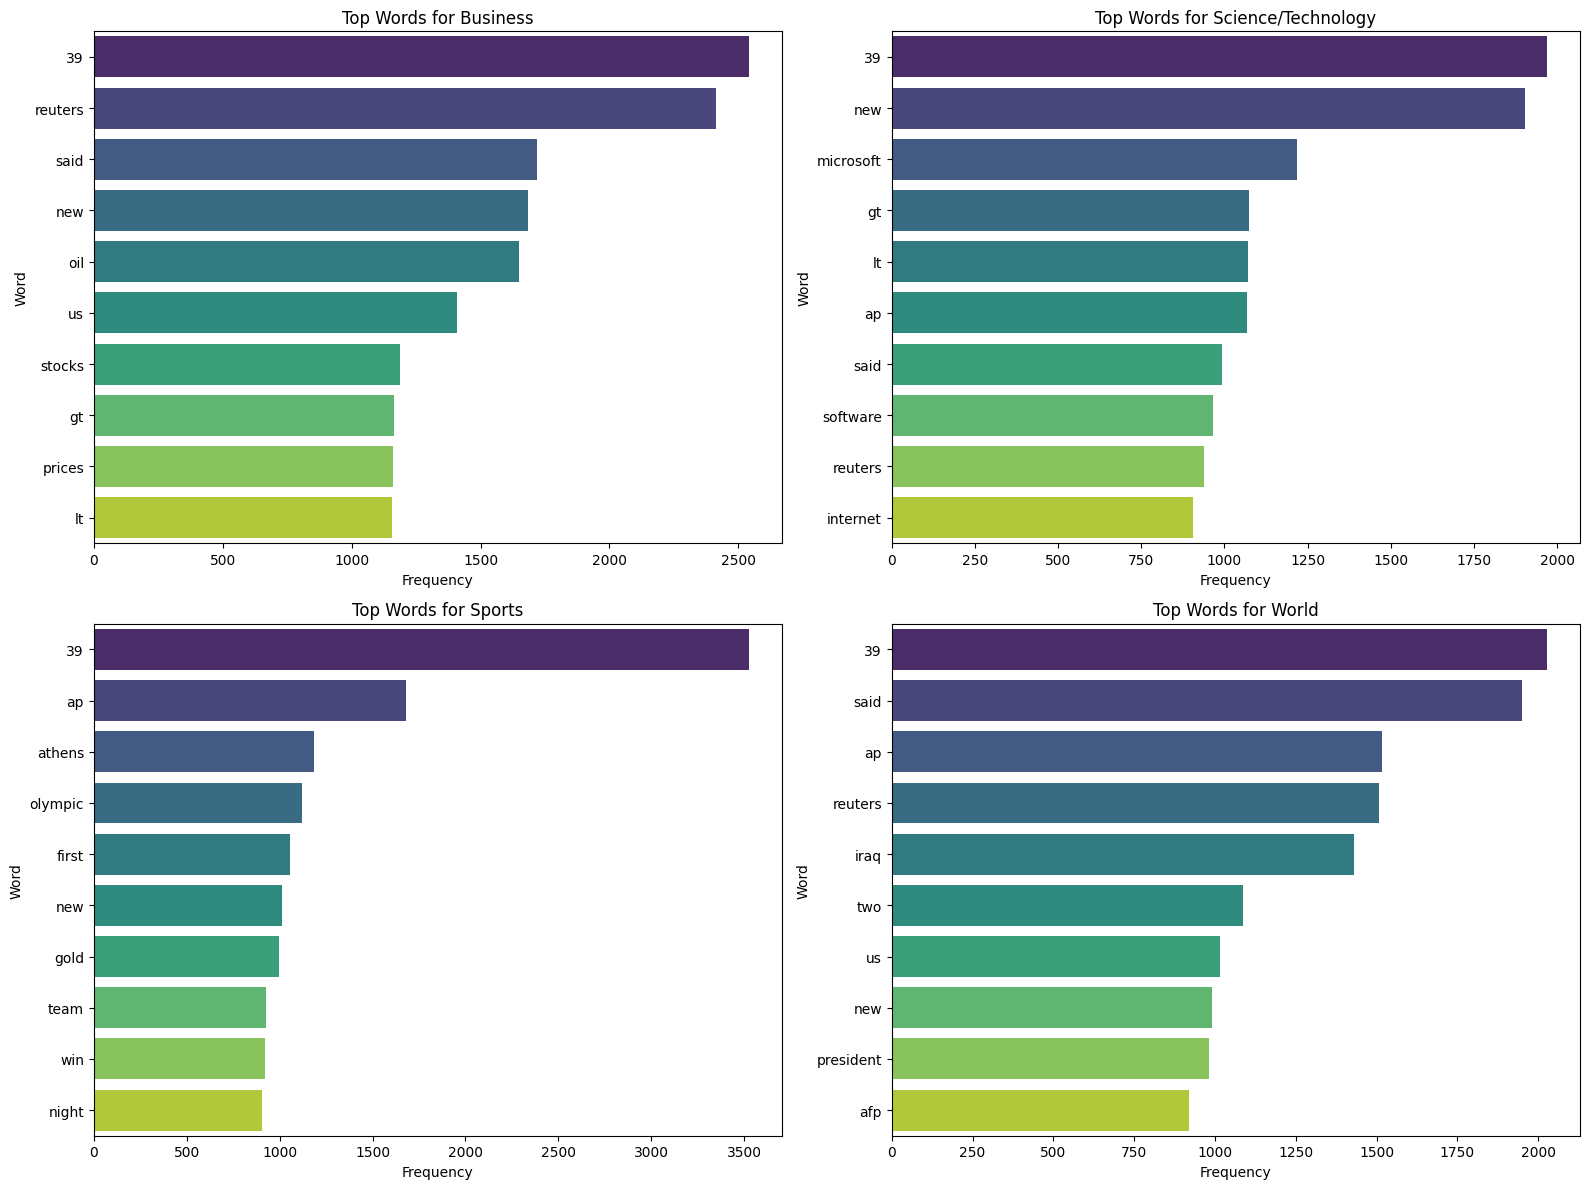

In [ ]:
stop_words = list(set(stopwords.words('english')))


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


plt.figure(figsize=(16, 12))
categories = df['category'].unique()
for idx, category in enumerate(categories, 1):
    plt.subplot(2, 2, idx)
    top_words = get_top_n_words(df[df['category'] == category]['text'], 10)
    top_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=top_df, palette='viridis')
    plt.title(f'Top Words for {category}')

plt.tight_layout()
plt.show()

above we analyzied article content across various categories by visualizing the most common words using bar plots. By filtering out common English stop words, the focus is on identifying key keywords that define each category of articles. This approach enables a clearer understanding of the predominant themes and subjects within each category based on word frequency. Such insights can be valuable for tasks like content analysis, topic modeling, and gaining deeper insights into language usage across different domains such as news, sports, business, and science/technology.

# Data Preprocessing

Handling NaN Values

In [ ]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Class Index    0
Title          0
Description    1
dtype: int64


as we can see there is one null value we can change the value to empty string

In [ ]:
df['text'].fillna('missing', inplace=True)

**Text Cleaning**

first we Clean the text to remove noise and irrelevant information. Common cleaning steps include:
Lowercasing the text.
Removing special characters, punctuation, and numerical values.
Removing stop words (common words like 'the', 'and', 'is' that do not carry significant meaning).
Removing URLs and other specific patterns that might not be relevant.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    clean_text = ' '.join(tokens)
    return clean_text

df['clean_text'] = df['text'].apply(clean_text)

**Tokenization and Lemmatization**

Tokenization splits text into individual words or tokens.
Lemmatization reduces words to their root form

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

df['clean_text'] = df['clean_text'].apply(lemmatize_text)

# Feature Engineering


TF-IDF (Term Frequency-Inverse Document Frequency) vectorization efficiently transforms text data into numerical features. By excluding stop words (common words like 'the', 'and') and setting max_df=0.7 to remove terms appearing in more than 70% of documents, TF-IDF enhances the representation's quality by focusing on meaningful terms. The dataset is split into training and test sets to evaluate the model's performance on unseen data, ensuring robustness and reliability in real-world applications.

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['Class Index'], test_size=0.2, random_state=42, stratify=df['Class Index'])
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Model Training with Hyperparameter Tuning

Support Vector Machines (SVM) are chosen as they are effective for text classification tasks, especially with high-dimensional data like TF-IDF vectors. A linear kernel is used for simplicity and interpretability, with regularization parameter C=1.0 for balanced regularization.


In [ ]:
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear', random_state=42)

After transforming the text data with TF-IDF vectorization and training the model, the next step involves evaluating its performance on the test dataset. This includes generating predictions to assess its generalization capabilities, accuracy as calculating metric interpreting these results to understand the model's strengths and weaknesses. and visualization tool such as confusion matrices provide additional insights into its performance across different classes. These steps collectively guide decisions on model deployment and potential refinements to enhance predictive accuracy.

Accuracy: 0.9094
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.87      0.89      1559
           2       0.94      0.98      0.96      1471
           3       0.89      0.88      0.89      1409
           4       0.89      0.90      0.90      1556

    accuracy                           0.91      5995
   macro avg       0.91      0.91      0.91      5995
weighted avg       0.91      0.91      0.91      5995



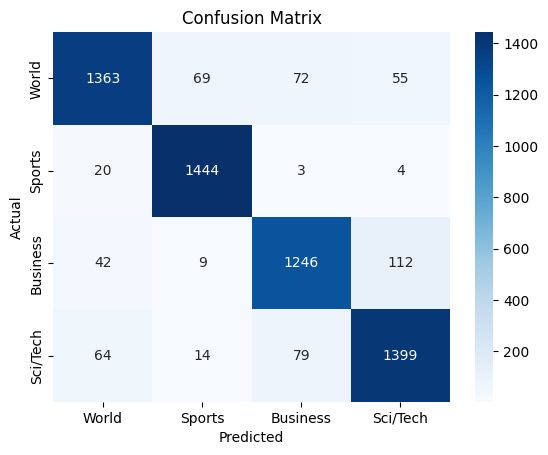

In [ ]:
y_pred = svm_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Predictions and Inference

A function is defined to classify new text inputs using the trained SVM model and TF-IDF vectorizer.
An example text input is classified to demonstrate the model's application on unseen data.


In [ ]:
def classify_news(text):
    text_tfidf = vectorizer.transform([text])
    label = svm_model.predict(text_tfidf)[0]

    categories = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}

    print(f'Predicted label: {label}')

    if label in categories:
        return categories[label]
    else:
        return "Unknown"

# Example of classification
example_text = "NASA launches new space mission to explore Mars."
predicted_category = classify_news(example_text)
print(f'The predicted category for the example text is: {predicted_category}')

Predicted label: 4
The predicted category for the example text is: Sci/Tech


# Final Discussion

Strengths:

*   Support Vector Machines (SVM) provide robust performance for text classification tasks, handling high-dimensional TF-IDF vector data effectively.
*   SVM with a linear kernel offers good interpretability and generalization capabilities, suitable for multi-class classification.

Limitations:


*   SVM's training time can be relatively longer on large datasets compared to simpler models like Naive Bayes.
*   SVM's performance depends on the choice of kernel and regularization parameters, requiring careful tuning.

Recommendations:


*   Explore kernel options (e.g., RBF, polynomial) and hyperparameter tuning (e.g., C regularization parameter) for potential performance improvements.
*   Consider ensemble methods or deep learning approaches (e.g., LSTM, BERT) for further enhancements, especially for complex text patterns.
